- `Written By   :` Mazi Boustani
- `Date         :` 08/05/2021
- `Purpose      :` Step by step introduction into RNN and LSTM followed by Pytorch example

All images captured from: https://youtu.be/qjrad0V0uJE

## Sequential data

Sequential data are kind of data were the order of the data matters.

Whenever the points in the dataset are dependent on the other points in the dataset.

Examples:
    - Time serices data: stock market, weather
    - Language data: such as words in a sentence
    - Boiological data: such as DNA sequence 
    

![Sequence Modeling Applications](images/sequence_modeling_applications.png)

## Problem with NN and sequence data

Neural networks and deep neural networks are not good at sequence data as their architecture cannot preserve the sequence of data.

__1- They have a fixed input length.__ That means all data being feeded into NN has to be always same size (like number of pixels in a photo). For examples, sentences with different number of words cannot be feeded into NN.

__2- They can not remember the sequence of the data.__ NN can not remember the order of data. NN would deal with these two data points as same "it is cold, not hot" and "it is hot, not cold".

__3- Can not share parameters across the sequence.__ So for example in sentence "What is your car? My car is Benz" NN should be able to tell how many times "car" repeated in a sentence but it does not recognize this type of pattern

 So we need Recurrent Neural Networks (RNN)

## Recurrent Neural Network (RNN)

RNNs are designed in a way to fix some of problems that traditional neural networks have such as three problems above. 

The difference between simple NN and RNN is that simple NN is unidirectional, which means it has only one direction.
But RNN, has loops inside it to persist the information over time and preserves the information.

![Feed-Forward_Network](images/Feed-Forward_Network.png)


![handeling_individual_time_steps](images/handeling_individual_time_steps.png )

![Neurons_with_Recurrence](images/Neurons_with_Recurrence.png)

![RNN_State_Update_and_Output](images/RNN_State_Update_and_Output.png)

RNN is training three weight matrices __Wxh__, __Whh__ and __Why__. These three matrices are same for each data point and only being updated though backpropagation process.


__Wxh:__ is the weight matrix that is applied at every timestamp to the input value

__Whh:__ is the weight matrix by which you update the previous state.

__Why:__ is the weight matrix that is applied at every timestamp to hidden state.


![Standard RNN](images/Standard RNN.png)

In RNN Since errors are calculated and are backpropagated at each timestamp it is called `Backpropagation Through Time`

![RNN_Backprop_through_time](images/RNN_Backprop_through_time.png)

Computing the gradients require a lot of factors of __Whh__ plus repeated gradient computations, which makes two set of problems. The 2 problems are in RNN, which LSTM helps solve: 

__1- Exploding Gradients:__ when many of the values, that are involved in the repeated gradient computations (such as weight matrix, or gradient themselves), are greater than 1. In this problem the gradients become extremely large, and it is very hard to optimize them. 

This problem can be solved via a process known as __Gradient Clipping__, which essentially scales back the gradient to smaller values.


__2- Vanishing Gradients:__ when many of the values that are involved in the repeated gradient computations (such as weight matrix, or gradient themselves) are too small or less than 1. In this problem the gradients become smaller and smaller as these computations occur repeatedly.

![Standard_RNN_Gradient_Flow_Vanishing](images/Standard_RNN_Gradient_Flow_Vanishing.png)

__Solution #1: Activation Function__
Using ReLU instead of `tanh`. ReLu's derivate for values above 0 is always 1.

__Solution #2: Parameter Initialization__
- initialize weights to identity matrix
- initialize biases to zero

These solutions help prevent the weights from shrinking to zero.

## LSTM

LSTMs are a special type Recurrent Neural Networks (RNNs). LSTM solves the vanishing gradients issue that RNN has. 

LSTMs are best suited for long term dependencies, it can hold more memory.

![LSTM_1](images/LSTM_1.png)


![LSTM](images/LSTM.png)

The key building block behind LSTM is a structure known as gates. Information is added or removed through these gate.

Because sigmoid function is force any value to be between 0-1 it acts like a gate, 0 means nothing or 1 means everything.


![LSTM_Gate](images/LSTM_Gate.png)

### LSTM steps:

__Forget:__ To decide which information the LSTM should keep or carry, and which information it should throw away. 

__Store:__ What part of new and old information is important to store in new state

__Update:__ To update the second cell state `ct`

__Ouput:__ To control what information send to next step `ht` and output `Yt`



![LSTM_forget](images/LSTM_forget.png)


![LSTM_store](images/LSTM_store.png)

![LSTM_update](images/LSTM_update.png)

![LSTM_output](images/LSTM_output.png)

# LSTM Code

In this example we use Starbuckss stock market price. The goal is to predict the Volume of Starbucks' stock price.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable

# for plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


## Download dataset
You can get the data from this link: https://query1.finance.yahoo.com/v7/finance/download/SBUX?period1=1576063151&period2=1607685551&interval=1d&events=history&includeAdjustedClose=true
    

## Data Preparation

In [2]:
# read csv file using Pandas library and set the Date column as index column and parse the Date column
data = pd.read_csv('./data/SBUX.csv', index_col='Date', parse_dates=True)


### Get familiar with data

In [3]:
print(data.shape)
data.head()


(253, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


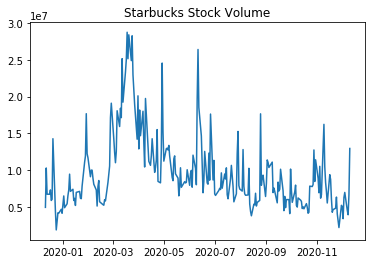

In [4]:
plt.title("Starbucks Stock Volume")
plt.plot(data['Volume'])


### Data preprocessing

In [5]:
# Get all columns except Volume and Date
X = data[['Open', 'High', 'Low', 'Close', 'Adj Close']]

# Get only Volume column as input data
y = data['Volume']
y = y.values.reshape(y.shape[0], 1)


When numerical input variables are scaled to a standard range machine learning algorithms perform better.

The two most popular techniques for __scaling__ numerical data prior to modeling are __normalization__ and __standardization__.

__Normalization__ also helps gradient descent to converge faster. Subtract each value by min and divide by range value. Values will be between 0 and 1. (MinMaxScalar)

`y = (x – min) / (max – min)`

__Standardizing__ a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

`y = (x – mean) / standard_deviation`

Notice that it is a regression problem, so it is very beneficial to scale your outputs otherwise you will be dealing with a huge loss.


In [6]:
ss = StandardScaler() 
mm = MinMaxScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)


In [7]:
# split data for training and test.
# we cannot shuffle data since the this
# is sequential data and the order is importand

# 200 for train and 53 for test

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :]


In [8]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)


Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [9]:
# convert all train and test numpy array to tensor format
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))


In [10]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))


In [11]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [12]:
# define LSTM Class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        # number of layers
        self.num_layers = num_layers
        # input size
        self.input_size = input_size
        # hidden state
        self.hidden_size = hidden_size
        # sequence length
        self.seq_length = seq_length
        
        # construct LSTM from Pytorch
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # fully connected 1
        self.fc_1 = nn.Linear(hidden_size, 128)
        
        # fully connected last layer
        self.fc = nn.Linear(128, 1)

        # activation function ad ReLu
        self.relu = nn.ReLU()

        
    def forward(self, x):
        
        # define hidden state h
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # define internal state c
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for dense layer next
        
        output = output[:, -1, :]
        # relu
        output = self.relu(output)
        # first dense layer
        output = self.fc_1(output)
        # relu
        output = self.relu(output)
        # final output
        output = self.fc(output)

        return output


In [13]:
# number of epochs to run
num_epochs = 1000

# learning rate value
learning_rate = 0.001

# number of features ['Open', 'High', 'Low', 'Close', 'Adj Close']
input_size = 5

# number of features in hidden state
hidden_size = 2

# number of stacked lstm layers
num_layers = 1


In [14]:
# call main LSTM class
lstm = LSTM(input_size,
            hidden_size,
            num_layers,
            X_train_tensors_final.shape[1])


In [15]:
# set loss function as mean-squared error for regression
loss_func = torch.nn.MSELoss()

# set optimizer as Adam
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


In [16]:
# train the network for each epoch
for epoch in range(num_epochs):
    
    # set gradient to 0
    optimizer.zero_grad()
    
    # forward pass
    outputs = lstm.forward(X_train_tensors_final)
 
    # get the loss function
    loss = loss_func(outputs, y_train_tensors)
    
    # backward pass
    loss.backward()
 
    # improve weights(backpropagation)
    optimizer.step()
    
    # for every 100 epochs show loss value.
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.05596
Epoch: 100, loss: 0.01837
Epoch: 200, loss: 0.01471
Epoch: 300, loss: 0.01305
Epoch: 400, loss: 0.01175
Epoch: 500, loss: 0.01123
Epoch: 600, loss: 0.01103
Epoch: 700, loss: 0.01086
Epoch: 800, loss: 0.01072
Epoch: 900, loss: 0.01060


## Prediction
Run predictions on the enite dataset.
Before running prediction on entire dataset we need to bring the original dataset into the model suitable format, which can be done by using similar code as above.

In [17]:
df_X_ss = ss.transform(data[['Open', 'High', 'Low', 'Close', 'Adj Close']]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 



In [18]:
train_predict = lstm(df_X_ss) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)


## Visualize the result

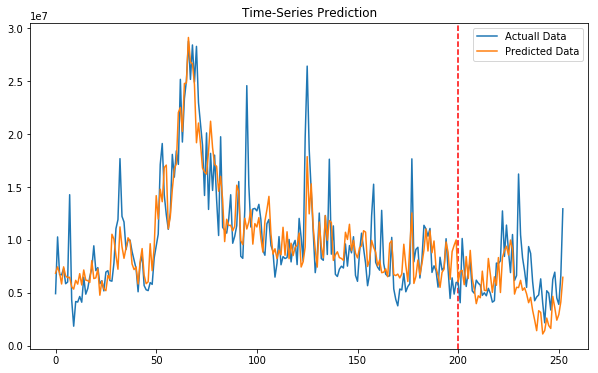

In [19]:
plt.figure(figsize=(10,6))
# draw the line to split train and test, data on the right are predicted (test).
plt.axvline(x=200, c='r', linestyle='--')

# actual plot
plt.plot(dataY_plot, label='Actuall Data')

# predicted plot
plt.plot(data_predict, label='Predicted Data')

plt.title('Time-Series Prediction')
plt.legend()
plt.show()


Source code: https://cnvrg.io/pytorch-lstm/